In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<h1><a href="https://www.kaggle.com/robervalt/sunspots" target="_blank">太阳黑子预测</a></h1>

In [2]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Lambda, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.callbacks import History, LearningRateScheduler
# 设置显存自动增长
physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, enable=True)

print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time: np.ndarray, series: np.ndarray, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-07-02 23:12:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-07-02 23:12:42 (116 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



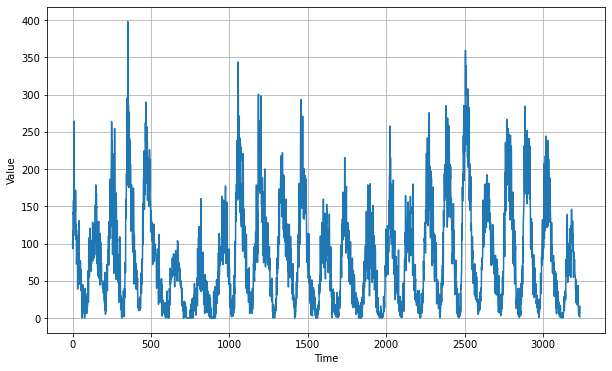

In [3]:
import csv
time_step = []
sunspots = []

with open('../data/sunspots/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

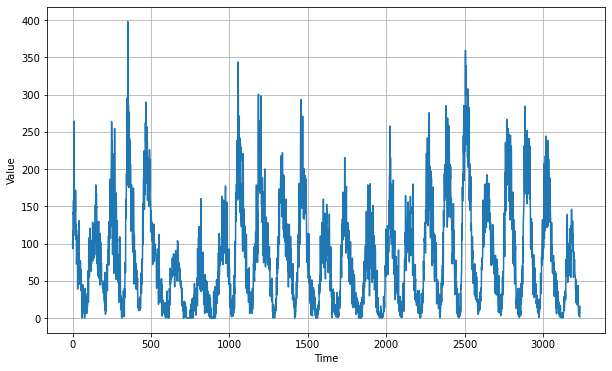

In [4]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series: np.ndarray, window_size: int, batch_size: int, shuffle_buffer: int) -> tf.raw_ops.PrefetchDataset:
    series: np.ndarray = tf.expand_dims(series, axis=-1)
    ds: tf.raw_ops.TensorSliceDataset = Dataset.from_tensor_slices(series)
    ds: tf.raw_ops.WindowDataset = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds: tf.raw_ops.FlatMapDataset = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds: tf.raw_ops.ShuffleDataset = ds.shuffle(shuffle_buffer)
    ds: tf.raw_ops.MapDataset = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model: Sequential, series: np.ndarray, window_size: int) -> np.ndarray:
    ds: tf.raw_ops.TensorSliceDataset = Dataset.from_tensor_slices(series)
    ds: tf.raw_ops.WindowDataset = ds.window(window_size, shift=1, drop_remainder=True)
    ds: tf.raw_ops.FlatMapDataset = ds.flat_map(lambda w: w.batch(window_size))
    ds: tf.raw_ops.PrefetchDataset = ds.batch(32).prefetch(1)
    forecast: np.ndarray = model.predict(ds)
    return forecast

In [8]:
clear_session()
set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = Sequential([
    Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", name="conv1d_1", input_shape=[None, 1]),
    LSTM(units=64, return_sequences=True, name="LSTM_2"),
    LSTM(units=64, return_sequences=True, name="LSTM_3"),
    Dense(units=30, activation="relu", name="dense_4"),
    Dense(units=10, activation="relu", name="dense_5"),
    Dense(units=1, activation=None, name="dense_6"),
    Lambda(function=lambda x: x * 400, name="lambda_6")
])


model.compile( 
    loss=Huber(),
    optimizer=SGD(lr=1e-8, momentum=0.9),
    metrics=["mae"]
)
history = model.fit(
    train_set, 
    epochs=100, 
    workers=-1,
    use_multiprocessing=True,
    callbacks=[
        LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    ]
)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 23ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 0s 18ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 0s 19ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 0s 19ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 0s 19ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

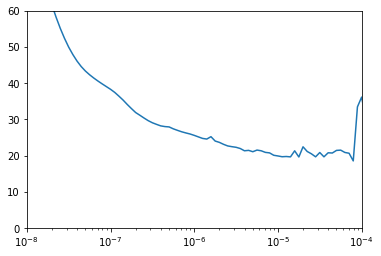

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
clear_session()
set_seed(51)
np.random.seed(51)
train_set: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
    Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", name="conv1d_1", input_shape=[None, 1]),
    LSTM(units=60, return_sequences=True, name="LSTM_2"),
    LSTM(units=60, return_sequences=True, name="LSTM_3"),
    Dense(units=30, activation="relu", name="dense_4"),
    Dense(units=10, activation="relu", name="dense_5"),
    Dense(units=1, activation=None, name="dense_6"),
    Lambda(function=lambda x: x * 400, name="lambda_6")
])


model.compile(
    loss=Huber(),
    optimizer=SGD(lr=1e-5, momentum=0.9),
    metrics=["mae"]
)
history: History = model.fit(
    train_set,
    epochs=500,
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/500
30/30 [==============================] - 0s 12ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 11ms/step - loss: 25.7614 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 11ms/step - loss: 22.0770 - mae: 22.5707
Epoch 4/500
30/30 [==============================] - 0s 11ms/step - loss: 20.4733 - mae: 20.9661
Epoch 5/500
30/30 [==============================] - 0s 11ms/step - loss: 19.7328 - mae: 20.2254
Epoch 6/500
30/30 [==============================] - 0s 11ms/step - loss: 19.2989 - mae: 19.7911
Epoch 7/500
30/30 [==============================] - 0s 11ms/step - loss: 18.7332 - mae: 19.2252
Epoch 8/500
30/30 [==============================] - 0s 11ms/step - loss: 18.1192 - mae: 18.6108
Epoch 9/500
30/30 [==============================] - 0s 11ms/step - loss: 18.1478 - mae: 18.6394
Epoch 10/500
30/30 [==============================] - 0s 11ms/step - loss: 17.9911 - mae: 18.4822
Epoch 11/500
30/30 [=========

30/30 [==============================] - 0s 11ms/step - loss: 15.9092 - mae: 16.3977
Epoch 167/500
30/30 [==============================] - 0s 11ms/step - loss: 15.9333 - mae: 16.4222
Epoch 168/500
30/30 [==============================] - 0s 11ms/step - loss: 16.0444 - mae: 16.5332
Epoch 169/500
30/30 [==============================] - 0s 11ms/step - loss: 15.8570 - mae: 16.3453
Epoch 170/500
30/30 [==============================] - 0s 11ms/step - loss: 15.9990 - mae: 16.4878
Epoch 171/500
30/30 [==============================] - 0s 11ms/step - loss: 15.8665 - mae: 16.3550
Epoch 172/500
30/30 [==============================] - 0s 11ms/step - loss: 15.8900 - mae: 16.3787
Epoch 173/500
30/30 [==============================] - 0s 11ms/step - loss: 15.8921 - mae: 16.3806
Epoch 174/500
30/30 [==============================] - 0s 11ms/step - loss: 16.0246 - mae: 16.5134
Epoch 175/500
30/30 [==============================] - 0s 11ms/step - loss: 15.9285 - mae: 16.4170
Epoch 176/500
30/30 [===

30/30 [==============================] - 0s 11ms/step - loss: 15.0846 - mae: 15.5716
Epoch 331/500
30/30 [==============================] - 0s 11ms/step - loss: 15.1129 - mae: 15.5995
Epoch 332/500
30/30 [==============================] - 0s 11ms/step - loss: 15.1487 - mae: 15.6353
Epoch 333/500
30/30 [==============================] - 0s 11ms/step - loss: 15.1103 - mae: 15.5970
Epoch 334/500
30/30 [==============================] - 0s 11ms/step - loss: 15.0079 - mae: 15.4942
Epoch 335/500
30/30 [==============================] - 0s 12ms/step - loss: 15.0298 - mae: 15.5164
Epoch 336/500
30/30 [==============================] - 0s 11ms/step - loss: 15.1048 - mae: 15.5917
Epoch 337/500
30/30 [==============================] - 0s 11ms/step - loss: 15.1276 - mae: 15.6146
Epoch 338/500
30/30 [==============================] - 0s 11ms/step - loss: 15.2443 - mae: 15.7308
Epoch 339/500
30/30 [==============================] - 0s 12ms/step - loss: 15.1930 - mae: 15.6802
Epoch 340/500
30/30 [===

30/30 [==============================] - 0s 11ms/step - loss: 14.4253 - mae: 14.9113
Epoch 495/500
30/30 [==============================] - 0s 11ms/step - loss: 14.5337 - mae: 15.0196
Epoch 496/500
30/30 [==============================] - 0s 11ms/step - loss: 14.4077 - mae: 14.8934
Epoch 497/500
30/30 [==============================] - 0s 11ms/step - loss: 14.4581 - mae: 14.9438
Epoch 498/500
30/30 [==============================] - 0s 11ms/step - loss: 14.4518 - mae: 14.9376
Epoch 499/500
30/30 [==============================] - 0s 12ms/step - loss: 14.4757 - mae: 14.9617
Epoch 500/500
30/30 [==============================] - 0s 11ms/step - loss: 14.8977 - mae: 15.3844


In [13]:
rnn_forecast: np.ndarray = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast: np.ndarray = rnn_forecast[split_time - window_size:-1, -1, 0]

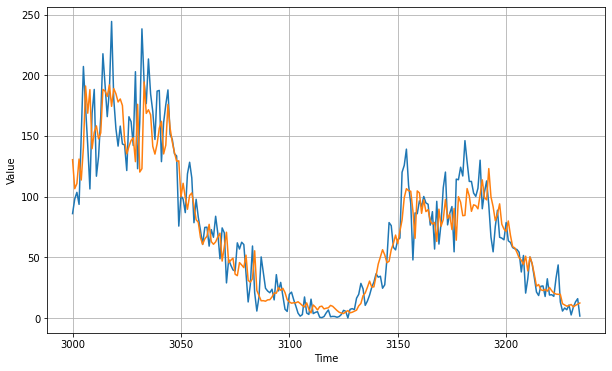

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
print(mean_absolute_error(x_valid, rnn_forecast).numpy())

15.59147


<Figure size 432x288 with 0 Axes>

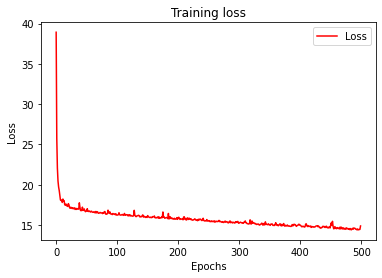

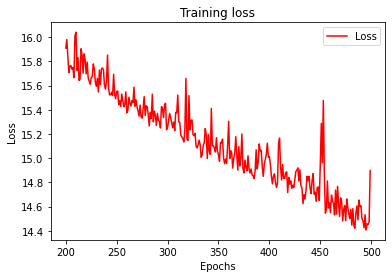

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [19]:
print(rnn_forecast)

[130.40746   106.51067   110.7466    130.94104   113.64076   140.39082
 191.11736   168.71667   188.12285   139.4447    153.00432   158.26628
 147.5441    152.49329   188.30893   187.01141   182.47905   192.06013
 174.37418   188.99083   184.7229    177.96164   180.42905   175.04935
 146.30576   135.19075   141.18945   146.25859   148.48053   128.7947
 176.04976   120.232544  123.016235  194.46347   168.52054   171.55566
 167.39537   141.37843   135.01535   143.41312   156.35898   162.0082
 135.1694    142.35217   175.94118   156.38072   144.96701   136.31093
 129.17566   129.46608    99.74923   110.98052    99.231705   89.576
 100.94609   102.99254    92.561874   80.971016   78.815506   66.32737
  60.644753   65.13627    67.361534   77.144875   62.875603   60.720795
  62.68788    66.76904    69.88221    46.874367   58.862972   70.63854
  45.54835    47.574284   49.30807    36.028416   34.856873   45.62515
  43.69165    41.50131    51.794224   30.973307   29.52975    32.371555
  55.343